1. Завантаження текстових даних та формування корпусу текстів...
Корпус текстів сформовано, кількість текстів: 10000

2. Завантаження ресурсів NLTK для токенізації, стоп-слів та лематизації...
Ресурси завантажено.

3. Препроцесінг тексту...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Препроцесинг завершено, кількість токенізованих текстів: 10000

4. Візуалізація найбільш та найменш часто вживаних слів...


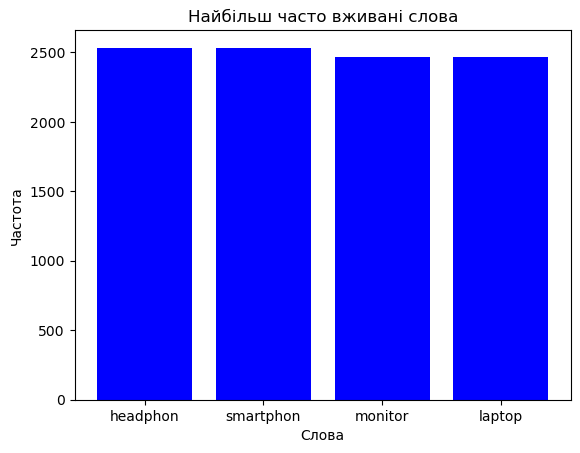

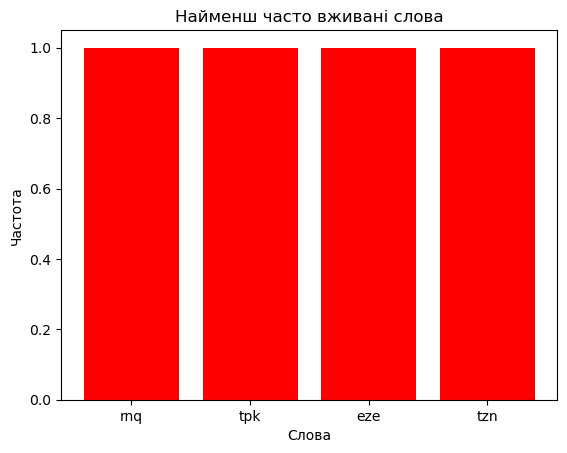

Візуалізація завершена.

5. Створення зваженої матриці термінів та кластеризація на основі TF-IDF...
Кластери побудовані:
   Product Name  Cluster
0       Laptop        0
1   Smartphone        2
2   Headphones        1
3      Monitor        2
4       Laptop        0


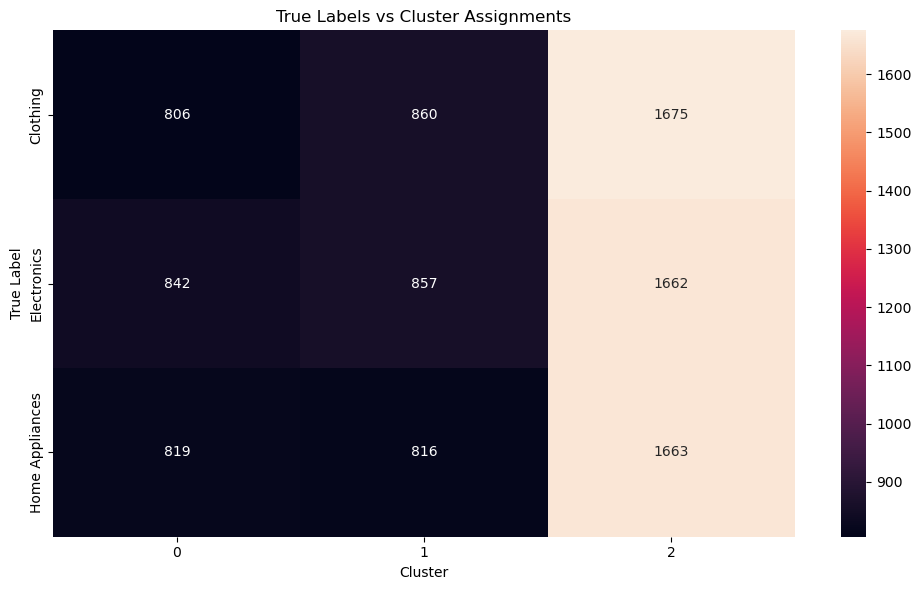

Кластеризація завершена.

6. Повторення попередніх етапів для суміші n-грам та порівняння результатів...


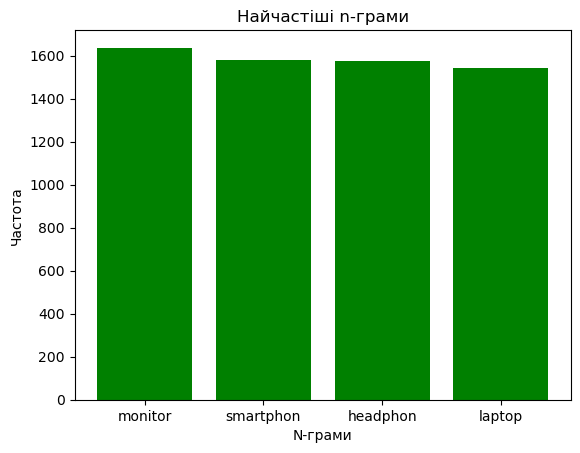

Аналіз з n-грамами завершено.



In [7]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns


# --- 1. Завантаження даних ---
print("1. Завантаження текстових даних та формування корпусу текстів...")
df = pd.read_csv("products.csv")

df['Product Description'] = df['Product Description'].fillna('')
df['Product Name'] = df['Product Name'].fillna('')
df['Product Tags'] = df['Product Tags'].fillna('')
texts = (df['Product Description'] + ' ' + df['Product Name'] + ' ' + df['Product Tags'])
print(f"Корпус текстів сформовано, кількість текстів: {len(texts)}\n")

# --- 2. Завантаження ресурсів ---
print("2. Завантаження ресурсів NLTK для токенізації, стоп-слів та лематизації...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
print("Ресурси завантажено.\n")

# --- 3. Препроцесінг ---
print("3. Препроцесінг тексту...")
def preprocess(text):
    # Нормалізація та токенізація (нижній регістр, розбиття слів)
    tokens = word_tokenize(text.lower())
    # Видалення пунктуації та цифр 
    tokens = [word for word in tokens if word.isalpha()]
    # Видалення стоп-слів
    tokens = [word for word in tokens if word not in stop_words]
    # Стеммінг (скорочення)
    tokens = [ps.stem(word) for word in tokens]
    # Лематизація 
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

tokens_lemmatized = [preprocess(text) for text in texts]
print(f"Препроцесинг завершено, кількість токенізованих текстів: {len(tokens_lemmatized)}\n")

# --- 4. Візуалізація найбільш та найменш часто вживаних слів ---
print("4. Візуалізація найбільш та найменш часто вживаних слів...")
word_freq = Counter(word for tokens in tokens_lemmatized for word in tokens)
common_words = word_freq.most_common(4)
rare_words = word_freq.most_common()[-4:]

if common_words:
    words, counts = zip(*common_words)
    plt.bar(words, counts, color='blue')
    plt.xlabel('Слова')
    plt.ylabel('Частота')
    plt.title('Найбільш часто вживані слова')
    plt.show()

if rare_words:
    words, counts = zip(*rare_words)
    plt.bar(words, counts, color='red')
    plt.xlabel('Слова')
    plt.ylabel('Частота')
    plt.title('Найменш часто вживані слова')
    plt.show()
print("Візуалізація завершена.\n")

# --- 5. Створення зваженої матриці термінів та кластеризація ---
print("5. Створення зваженої матриці термінів та кластеризація на основі TF-IDF...")
try:
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform([" ".join(tokens) for tokens in tokens_lemmatized])

    # Кластеризація за допомогою KMeans
    optimal_clusters = len(set(df['Product Category'].dropna()))
    km = KMeans(n_clusters=optimal_clusters, random_state=42)
    km.fit(X)

    df['Cluster'] = km.labels_
    print("Кластери побудовані:\n", df[['Product Name', 'Cluster']].head())


      # Кількість кластерів дорівнює кількості унікальних категорій
    true_labels = df['Product Category']
    kmeans = KMeans(n_clusters=true_labels.nunique(), random_state=42)
    df['Cluster'] = kmeans.fit_predict(X)
    
    # Побудова графіку
    plt.figure(figsize=(10, 6))
    heatmap_data = pd.crosstab(true_labels, df['Cluster'])
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap="rocket")
    plt.title("True Labels vs Cluster Assignments")
    plt.xlabel("Cluster")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

except ValueError as e:
    print("Помилка TF-IDF:", e)
print("Кластеризація завершена.\n")

# --- 6. Повторити попередні етапи для суміші n-грам ---
print("6. Повторення попередніх етапів для суміші n-грам та порівняння результатів...")
try:
    vectorizer_ngram = TfidfVectorizer(ngram_range=(2, 3))
    X_ngram = vectorizer_ngram.fit_transform([" ".join(tokens) for tokens in tokens_lemmatized])

    ngram_features = vectorizer_ngram.get_feature_names_out()
    ngram_freq = Counter(" ".join(ngram_features).split())
    common_ngrams = ngram_freq.most_common(4)

    if common_ngrams:
        ngram_words, ngram_counts = zip(*common_ngrams)
        plt.bar(ngram_words, ngram_counts, color='green')
        plt.xlabel('N-грами')
        plt.ylabel('Частота')
        plt.title('Найчастіші n-грами')
        plt.show()
    else:
        print("N-грамів не знайдено.")

except ValueError as e:
    print("Помилка n-грамів:", e)

print("Аналіз з n-грамами завершено.\n")
